In [ ]:
!pip install --upgrade 'git+https://github.com/azavea/nasa-hyperspectral.git@feature/mif-decorrelation#egg=hyperspectral&subdirectory=src/hyperspectral'
!pip install rasterio

In [ ]:
from google.colab import drive
drive.mount("~/data")

Mounted at /root/data


In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm

from hyperspectral.spectra import SpectralLibrary, Spectrum

In [ ]:
loaded = np.load('/root/data/MyDrive/Hyperspectral/tpa_extract.npz')
extract = loaded['extract']
active = loaded['active']
dirty = loaded['dirty']
r,c,_ = extract.shape
r,c

(89, 85)

In [ ]:
samples = extract.reshape((r*c,-1))
magnitudes = np.linalg.norm(samples, ord=2, axis=1)
samples = samples / magnitudes[:, None]
n_samples, p = samples.shape
n_samples, p

(7565, 154)

In [ ]:
def whitening_matrix(m):
    old_shape = m.shape
    m = m.reshape(-1, old_shape[-1])
    mean = np.mean(m, axis=0)
    cov = np.cov(m - mean, rowvar=False)
    w, v = np.linalg.eig(cov)
    W = np.matmul(np.matmul(v, np.diag(1 / np.sqrt(1e-6 + w))), v.T)
    return W, mean

In [ ]:
W, mean = whitening_matrix(samples)

In [ ]:
centered_pixels = samples - mean

In [ ]:
# get the computation device
def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    else:
        return 'cpu'

device = torch.device(get_device())
device

device(type='cpu')

In [ ]:
class Extract(torch.nn.Module):
    
    def __init__(self, W, bias, target):
        super(Extract, self).__init__()

        self.W = torch.from_numpy(W.astype(np.float)).unsqueeze(2)
        #_W = torch.nn.parameter.Parameter(_W)
        #self.register_parameter('W', _W)

        _bias = torch.from_numpy(np.array(bias).astype(np.float)).reshape(1)
        _bias = torch.nn.parameter.Parameter(_bias)
        self.register_parameter('bias', _bias)

        _target = torch.from_numpy(target.astype(np.float)).reshape((1,-1,1))
        _target = torch.nn.parameter.Parameter(_target)
        self.register_parameter('target', _target)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = F.conv1d(x, self.W)
        y = F.conv1d(self.target, self.W)
        x = F.conv1d(x, y, self.bias)
        x = self.relu(x)
        return x

In [ ]:
clear_pixels = centered_pixels[np.logical_not(dirty.flatten())]
signal_pixels = centered_pixels[active.flatten()]
clear_to_signal_ratio = len(clear_pixels) // len(signal_pixels)
clear_to_signal_ratio

578

In [ ]:
ps = torch.from_numpy(np.vstack([clear_pixels] + [signal_pixels] * clear_to_signal_ratio).astype(np.float)).unsqueeze(2).to(device)
#v = torch.from_numpy(np.vstack([signal_pixels] * clear_to_signal_ratio)).unsqueeze(2).to(device)

ls = torch.from_numpy(np.concatenate([np.zeros((clear_pixels.shape[0], 1)), np.ones((v.shape[0], 1))], 0)).unsqueeze(2).to(device)

In [ ]:
ps.shape, ls.shape

(torch.Size([13875, 154, 1]), torch.Size([13875, 1, 1]))

In [ ]:
model = Extract(W, 0, signal_pixels[0]).to(device)

In [ ]:
for parameter in model.parameters():
    parameter.requires_grad = True

obj = torch.nn.BCEWithLogitsLoss().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [ ]:
for i in tqdm(range(0,500)):
    opt.zero_grad()
    pred = model(ps)
    loss = obj(pred, ls)
    loss.backward()
    opt.step()

In [ ]:
inferred_target = model.target.cpu().detach().numpy()[0,:,0]
bias = model.bias.cpu().item()

In [ ]:
bias

-0.09793223340386742

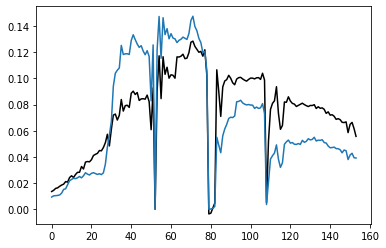

In [ ]:
#for s in signal_pixels:
#  plt.plot(s + mean)
plt.plot(inferred_target + mean, "k")
plt.plot(samples[100])

In [ ]:
np.savez('/root/data/MyDrive/Hyperspectral/tpa_spectrum.npz', target=inferred_target + mean)